_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: Luca Kosina, Sascha Mühlinghaus, Max Bardelang

LLM Disclaimer: ChatGPT for help with data analysis, Perplexity for literature search and Copilot for code completion.

# Neural Data Science Project 01

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

## Context
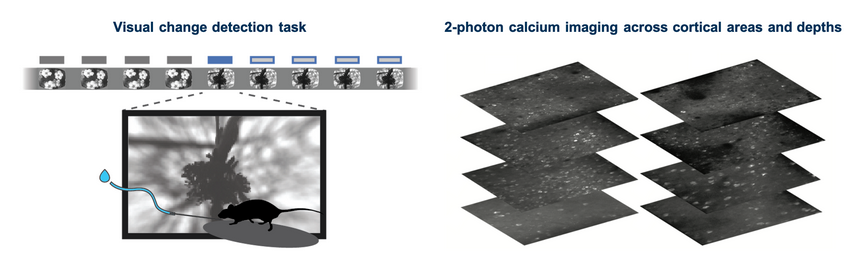

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.

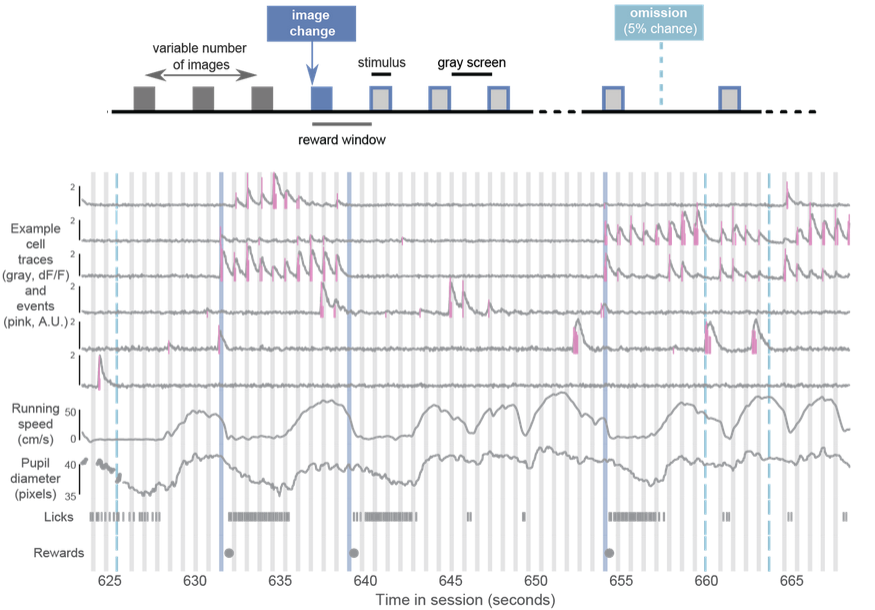

The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the ROI masks for each cell
- a maximum activity projection of the recorded area
- running speed
- table of stimulus epochs

You will only work with a drifting grating stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

In [1]:
# import packages here

import numpy as np
import pandas as pd
import jupyter_black
from scipy import signal
from scipy.signal import butter, filtfilt
from scipy import optimize as opt
import matplotlib.pyplot as plt
import seaborn as sns

jupyter_black.load()
from typing import Tuple

In [2]:
# load data
def load_data(path="."):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(path + "/dff_data_dsi.npz", allow_pickle=True)
    data = dict(data)
    array2df(
        data,
        "stim_table",
        ["frequency", "direction", "blank_sweep", "start", "end"],
    )
    array2df(data, "stim_epoch_table", ["stimulus", "start", "end"])

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")


data = load_data(
    path="/Users/sascha/Library/Mobile Documents/com~apple~CloudDocs/Uni_Tübingen/Semester2/NeuralDataScience/Assignments/FinalProject/data/project-01"
)  # adjust the path as necessary

print("Overview of the data")
print_info(data)

Overview of the data
[t] - <class 'numpy.ndarray'>, - (115471,)
[dff] - <class 'numpy.ndarray'>, - (106, 115471)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (628, 5)
[roi_masks] - <class 'numpy.ndarray'>, - (106, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 115471)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)



## Question

**Is there spatial structure in the preferred orientation/direction/frequency?**

Implement all steps of the processing pipeline that are necessary to answer them. Think of:
1. Pre-processing
2. Spike inference
3. Tuning function fitting
4. Statistical testing.

It is sufficient to assess spatial structure visually. Additional insights and analyses will be positively factored into the overall grade.

# Implementation

We are following these steps to answer the questions:

We filter the data to have smoother signals by cutting out low frequencies to be able to detect spikes in high-frequency components.
We then calculate the threshold for spikes and detect positions of spikes in the filtered data.
Because we are interested in the specificity of neurons to stimuls characteristics we look at each trial of stimulus presentation and segment the reactions of neurons in each stimulus segment.
Since only certain trials show detect spikes we filter out trials for each neurons in which spikes occur to continue the analysis with these.
We then correct each stimulus reaction to the baseline activity of the neuron before the stimulus presentation.
We then fit tuning curves to the detected spikes after stimulus presentation and by permutation analysis check which neurons have certain orientation, direction and frequency preference.
Then using the mask we plot the entire filed of neurons with their respective preference to first check if we can visually see an organization of the neurons into columns.
We statistically analyze this by ...



# 1 Pre-processing

## 1.1 Data Exploration

We start by looking at what the the raw data looks like for one example neuron:

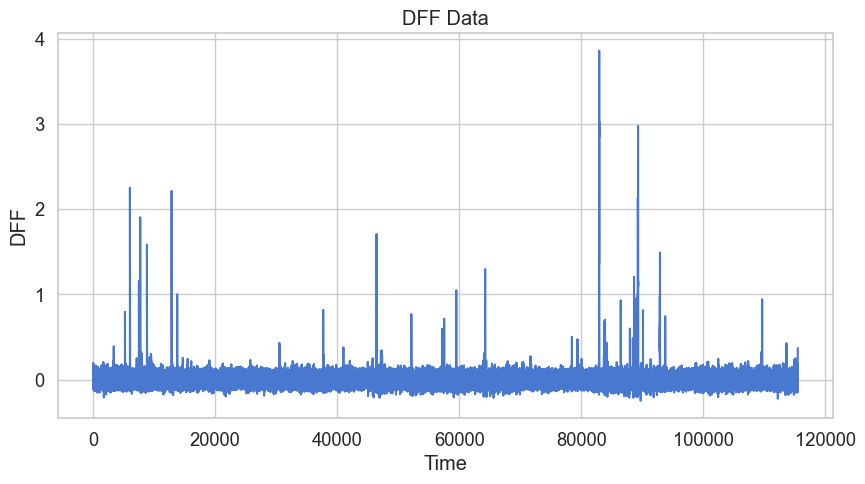

In [3]:
# plot dff
sns.set(style="whitegrid", palette="muted", font_scale=1.2)


def plot_dff(data, neuron=0):
    """
    Plot the dff data for a given neuron and stimulus epoch.

    Parameters:
    - data: The data dictionary containing dff data.
    - neuron: The index of the neuron to plot.
    - stim_epoch: The index of the stimulus epoch to plot.
    """
    dff = data["dff"]

    plt.figure(figsize=(10, 5))
    plt.plot(
        dff[neuron],
        label=f"Neuron {neuron}",
    )
    plt.title("DFF Data")
    plt.xlabel("Time")
    plt.ylabel("DFF")
    plt.show()


# Example plot for one neuron
plot_dff(data)

To see more of the frequency structure let´s look at a spcific segment of the data:

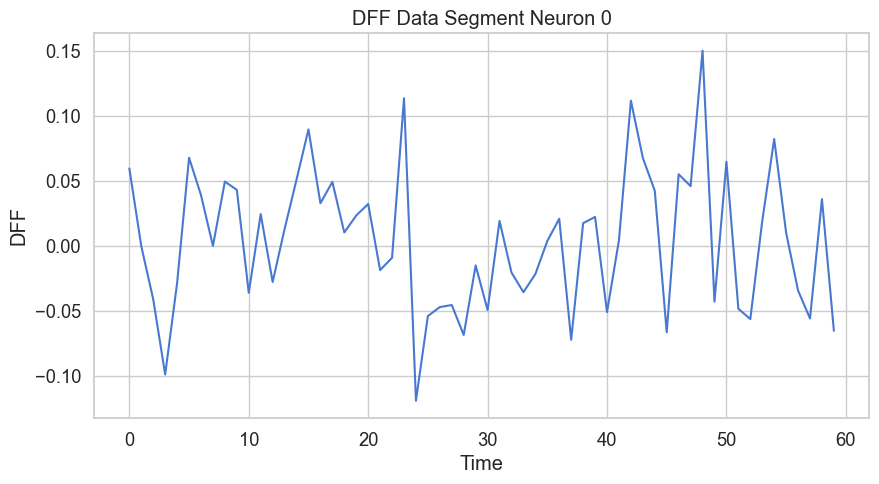

In [4]:
# look at specific trial / segment of the data for the example neuron
plt.figure(figsize=(10, 5))

# extract stimulus epoch for the example neuron
stim_epoch = data["stim_table"].iloc[0]  # First stimulus epoch
start, end = int(stim_epoch["start"]), int(stim_epoch["end"])

plt.plot(
    data["dff"][0][start:end],
    label="Neuron 0",
)
plt.title("DFF Data Segment Neuron 0")
plt.xlabel("Time")
plt.ylabel("DFF")
plt.show()

## 1.2 Data Segmentation

There are stimulus epochs with a drifting grating stimulus which we have to extract from the data. We can use the `stim_epoch_table` to segment the data into these epochs. Additionally, we can use the `stim_table` to get the parameters of the stimulus (e.g. frequency, direction, etc.) and the trials of the epochs.

In [5]:
stim_table = data["stim_table"]
stim_epoch_table = data["stim_epoch_table"]

In [6]:
stim_epoch_table

,stimulus,start,end
0,drifting_gratings,747,18775
1,natural_movie_three,19709,37767
2,natural_movie_one,38671,47699
3,drifting_gratings,48602,66630
4,spontaneous,66780,75697
5,natural_movie_three,75698,93756
6,drifting_gratings,94659,115215


In [7]:
def build_dff_dataframe(dff, stims, stim_epoch_table):
    """
    builds a dataframe containing dff traces matched to stimulation trials.
    only includes trials that fall within drifting grating stimulus epochs.

    parameters:
    - dff: array of shape (neurons, frames), containing dff signal values
    - stims: dataframe with columns 'start', 'end', 'frequency', 'direction', 'blank_sweep'
             each row represents a trial
    - stim_epoch_table: dataframe with columns 'stimulus', 'start', 'end'

    returns:
    - dff_df: dataframe with trial-aligned dff data
    """

    # convert start and end columns to integers
    stim_epoch_table["start"] = stim_epoch_table["start"].astype(int)
    stim_epoch_table["end"] = stim_epoch_table["end"].astype(int)
    stims["start"] = stims["start"].astype(int)
    stims["end"] = stims["end"].astype(int)

    # get only drifting gratings epochs
    drifting_epochs = stim_epoch_table[
        stim_epoch_table["stimulus"] == "drifting_gratings"
    ].reset_index(drop=True)

    # create interval index for drifting grating epochs
    epoch_intervals = pd.IntervalIndex.from_arrays(
        drifting_epochs["start"], drifting_epochs["end"], closed="both"
    )

    records = []

    for trial_number, stim in stims.iterrows():
        start, end = stim["start"], stim["end"]

        start = int(stim["start"])
        end = int(stim["end"])

        # check if trial is fully within a drifting grating epoch
        epoch_match = epoch_intervals.contains(start) & epoch_intervals.contains(end)
        if not any(epoch_match):
            continue

        epoch_id = epoch_match.argmax()

        frequency = stim["frequency"]
        direction = stim["direction"]
        blank_sweep = stim["blank_sweep"]

        for neuron_idx in range(dff.shape[0]):
            trial_dff = dff[neuron_idx, start : end + 1]
            rel_times = np.arange(0, end - start + 1)
            frame_indices = np.arange(start, end + 1)

            for f_idx, rel_time, dff_val in zip(frame_indices, rel_times, trial_dff):
                records.append(
                    {
                        "Neuron": neuron_idx,
                        "Trial": trial_number,
                        "Epoch": epoch_id,
                        "FrameIdx": f_idx,
                        "Frequency": frequency,
                        "BlankSweep": blank_sweep,
                        "Dir": direction,
                        "relTime": rel_time,
                        "DFF": dff_val,
                    }
                )

    dff_df = pd.DataFrame.from_records(records)

    return dff_df

In [8]:
dff_df = build_dff_dataframe(
    data["dff"],
    stim_table,
    stim_epoch_table,
)

# exclude trials with blank sweeps
dff_df = dff_df[dff_df["BlankSweep"] == 0]
# add 1 to values of Neuron, Trial and Epoch
dff_df["Neuron"] += 1
dff_df["Trial"] += 1
dff_df["Epoch"] += 1
dff_df

,Neuron,Trial,Epoch,FrameIdx,Frequency,BlankSweep,Dir,relTime,DFF
0,1,1,1,747,1.0,0.0,225.0,0,0.059512
1,1,1,1,748,1.0,0.0,225.0,1,-0.000203
2,1,1,1,749,1.0,0.0,225.0,2,-0.041120
3,1,1,1,750,1.0,0.0,225.0,3,-0.098806
4,1,1,1,751,1.0,0.0,225.0,4,-0.028460
...,...,...,...,...,...,...,...,...,...
4040397,106,628,3,115211,1.0,0.0,180.0,56,-0.018237
4040398,106,628,3,115212,1.0,0.0,180.0,57,-0.000033
4040399,106,628,3,115213,1.0,0.0,180.0,58,-0.077658
4040400,106,628,3,115214,1.0,0.0,180.0,59,0.000000


After having created a dataframe with the segmented data and having filtered out the blank sweeps we can start the actual processing of the timeseries data. We have seen that there are a lot of high frequency components in the data which we want to filter out to be able to detect spikes in the data. We can use a butter bandpass filter to cut out low frequencies and filtfilt function to apply the filter to the data without introducing phase shifts.

In [ ]:
# factor to control the false positive rate with N * sigma
N = 2
# estimate the sampling frequency
dt = np.mean(np.diff(data["t"]))
print("dt:", dt)
fs = np.round(1 / dt)
print("fs:", fs)
cut_off = 0.1  # cutoff frequency for the filter
print("cut_off:", cut_off)

dt: 0.03325489373863341
fs: 30.0
cut_off: 0.1


We can see that there is a slight low frequency oscillation in the data which we now want to filter out.

We are utilizing a butterworth filter like in the coding lab.

We choose N to be lower than the default value of 5 to increase the sensitivity of the spike detection.

In [10]:
def butterworth_filter_df(df, cutoff=cut_off, fs=fs, order=2):
    """
    Apply a Butterworth filter to the data.

    Parameters:
    - df: The dataframe containing the data to filter.
    - cutoff: The cutoff frequency of the filter.
    - fs: The sampling frequency of the data.
    - order: The order of the filter.

    Returns:
    - The filtered data.
    """
    data = df["DFF"].values  # Extract the DFF values from the dataframe

    b, a = butter(order, cut_off, fs=fs, btype="high", analog=False)
    filtered_data = filtfilt(b, a, data)

    # remove the DFF column from the dataframe
    df = df.drop(columns=["DFF"])
    # add the filtered data as a new column
    df["FilteredDFF"] = filtered_data

    return df

In [11]:
def butterworth_filter(data, cutoff=cut_off, fs=fs, order=2):
    """
    Apply a Butterworth filter to the data.

    Parameters:
    - data: The raw data to filter.
    - cutoff: The cutoff frequency of the filter.
    - fs: The sampling frequency of the data.
    - order: The order of the filter.

    Returns:
    - The filtered data.
    """
    b, a = butter(order, cut_off, fs=fs, btype="high", analog=False)
    filtered_data = filtfilt(b, a, data)

    return filtered_data

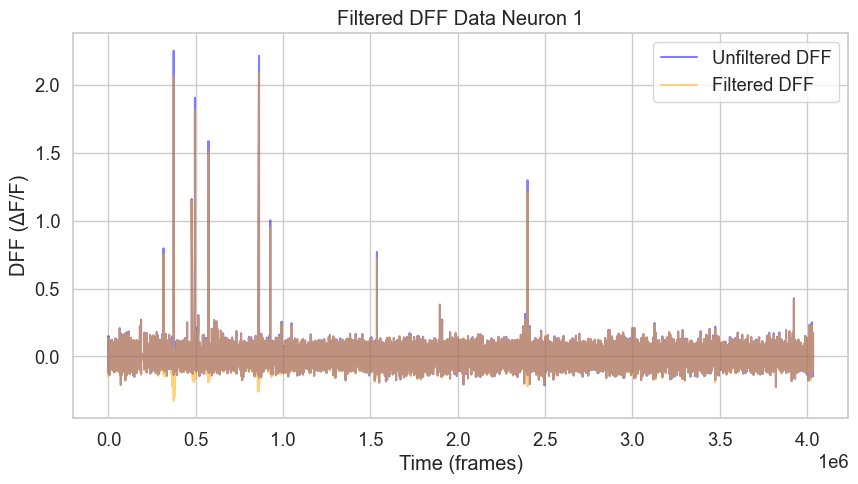

In [12]:
# Apply the filter to the dff data for one example neuron 0
filtered_dff = butterworth_filter_df(
    dff_df[dff_df["Neuron"] == 1], cutoff=cut_off, fs=fs
)
# Plot the filtered dff data
plt.figure(figsize=(10, 5))
plt.plot(
    dff_df[dff_df["Neuron"] == 1]["DFF"],
    label=f"Unfiltered DFF",
    color="blue",
    alpha=0.5,
)
plt.plot(filtered_dff["FilteredDFF"], label="Filtered DFF", color="orange", alpha=0.5)
plt.title("Filtered DFF Data Neuron 1")
plt.xlabel("Time (frames)")
plt.ylabel("DFF (ΔF/F)")
plt.legend()
plt.show()

The filtering process has smoothed the signal, reducing noise while preserving the essential features of the neural activity. This will help in further analyses such as identifying peaks, calculating statistics, or visualizing the data more clearly.
We can now therefore apply the filter to all neurons:

In [13]:
# apply filter to all neurons
filtered_dff_df = butterworth_filter_df(dff_df, cutoff=cut_off, fs=fs)
filtered_dff_df

,Neuron,Trial,Epoch,FrameIdx,Frequency,BlankSweep,Dir,relTime,FilteredDFF
0,1,1,1,747,1.0,0.0,225.0,0,0.004270
1,1,1,1,748,1.0,0.0,225.0,1,-0.055291
2,1,1,1,749,1.0,0.0,225.0,2,-0.096058
3,1,1,1,750,1.0,0.0,225.0,3,-0.153601
4,1,1,1,751,1.0,0.0,225.0,4,-0.083116
...,...,...,...,...,...,...,...,...,...
4040397,106,628,3,115211,1.0,0.0,180.0,56,-0.018092
4040398,106,628,3,115212,1.0,0.0,180.0,57,-0.000134
4040399,106,628,3,115213,1.0,0.0,180.0,58,-0.078012
4040400,106,628,3,115214,1.0,0.0,180.0,59,-0.000614


## Spike Inference

We can now continue with the analysis using the filtered data. First, we detect the spikes in the entire dataset for each neuron.

In [14]:
def detect_spikes(
    df: pd.DataFrame, fs: float, N: int = 5, lockout: float = 1.0
) -> tuple[np.ndarray, np.ndarray, np.float64]:
    """Detect spikes in the signal x and compute a threshold.

    Parameters
    ----------

    df: pd.DataFrame
        The filtered DFF data.

    fs: float
        the sampling rate (in Hz).

    N: int
        An arbitrary number with which you multiply with the standard deviation
        to set a threshold that controls your false positive rate. Default is 5
        but you should try changing it and see how it affects the results.

    lockout: float
        a window of 'refractory period', within which there's only one spike.
        Default is 1ms but you should also try changing it.


    Returns
    -------

    s: np.array, (n_spikes, )
        Spike location / index in the signal x.

    t: np.array, (n_spikes, )
        Spike time in ms. By convention the time of the zeroth sample is 0 ms.

    thrd: float
        Threshold = -N * sigma.


    Tips
    ----

    You can use scipy functions like find_peaks for the detection.
    Note: There are four channels in signal x.

    """
    x = df[
        "FilteredDFF"
    ].values.flatten()  # extract the filtered DFF values from the dataframe

    # compute the robust s.d. and calculate the threshold
    sigma = np.median(np.abs(x - np.mean(x))) / 0.6745
    threshold = N * sigma

    # candidate positive peaks
    pos_peaks, _ = signal.find_peaks(x, distance=lockout)
    pos_peaks = pos_peaks[x[pos_peaks] >= threshold]

    # negative peaks are not used because they occur too close to the positive peaks
    peaks = pos_peaks

    spike_times = peaks * (1000 / fs)  # convert to ms

    # add col spikes to the dataframe
    df["Spike"] = 0
    df.loc[df.index[peaks], "Spike"] = 1

    return df, spike_times, threshold

/var/folders/_w/fvv3yfg57mj4b3g4yftq72cr0000gn/T/ipykernel_61823/1818561708.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Spike"] = 0


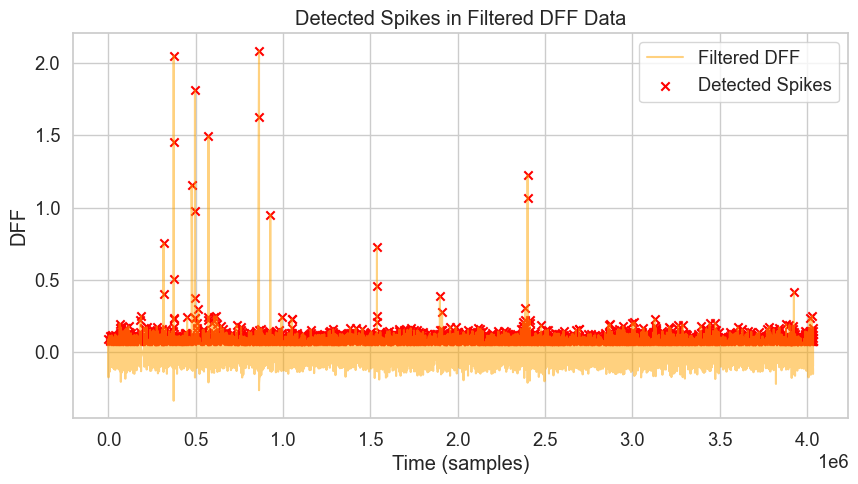

In [15]:
# detect spikes in the filtered dff data for example neuron 1
neuron1, spike_times, threshold = detect_spikes(
    filtered_dff_df[filtered_dff_df["Neuron"] == 1], fs=fs, N=N, lockout=1.0
)

# plot the detected spikes
plt.figure(figsize=(10, 5))
plt.plot(
    neuron1["FilteredDFF"],
    label="Filtered DFF",
    color="orange",
    alpha=0.5,
)
plt.scatter(
    neuron1.index[neuron1["Spike"] == 1],
    neuron1["FilteredDFF"][neuron1["Spike"] == 1],
    color="red",
    label="Detected Spikes",
    marker="x",
)
plt.title("Detected Spikes in Filtered DFF Data")
plt.xlabel("Time (samples)")
plt.ylabel("DFF")
plt.legend()
plt.show()

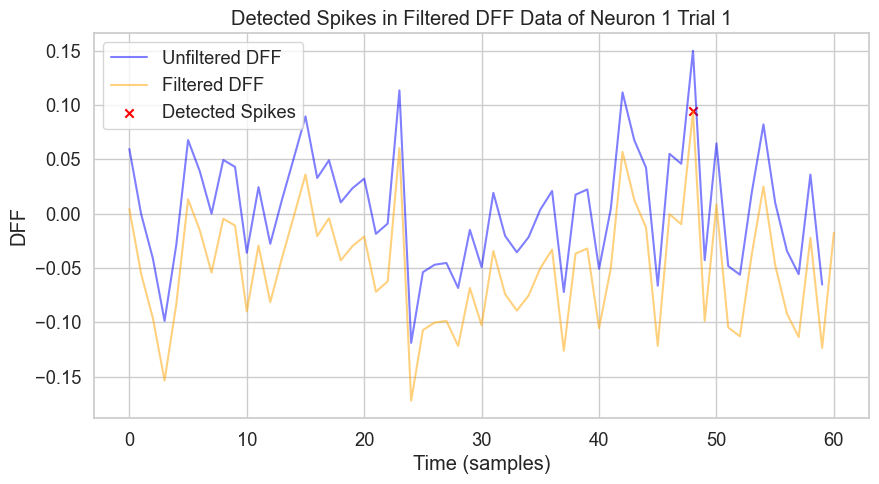

In [16]:
# get start and end of the first trial
start, end = stim_table.iloc[0][["start", "end"]].astype(int)

# filter the dataframe for neuron 1 and trial 1
neuron1_trial1 = neuron1[neuron1["Trial"] == 1]

neuron1_trial1["FilteredDFF"][start:end]
# plot trial 1 for neuron 1
plt.figure(figsize=(10, 5))
plt.plot(data["dff"][0][start:end], label="Unfiltered DFF", color="blue", alpha=0.5)
plt.plot(
    neuron1_trial1["FilteredDFF"],
    label="Filtered DFF",
    color="orange",
    alpha=0.5,
)
# add spikes
plt.scatter(
    neuron1_trial1.index[neuron1_trial1["Spike"] == 1],  # get the indices of the spikes
    neuron1_trial1["FilteredDFF"][neuron1_trial1["Spike"] == 1],
    # get the filtered DFF values at the spike indices
    color="red",
    label="Detected Spikes",
    marker="x",
)
plt.title("Detected Spikes in Filtered DFF Data of Neuron 1 Trial 1")
plt.xlabel("Time (samples)")
plt.ylabel("DFF")
plt.legend()
plt.show()

Again we apply the spike detection to all neurons:

In [70]:
filtered_dff_df, spike_times, thresholds = detect_spikes(
    filtered_dff_df, fs=fs, N=N, lockout=1.0
)

In [31]:
filtered_dff_df  # total number of spikes detected
spike_df = filtered_dff_df[filtered_dff_df["Spike"] == 1]
spike_df  # dataframe with spikes

,Neuron,Trial,Epoch,FrameIdx,Frequency,BlankSweep,Dir,relTime,FilteredDFF,Spike
5,1,1,1,752,1.0,0.0,225.0,5,0.068755,1
23,1,1,1,770,1.0,0.0,225.0,23,0.126294,1
42,1,1,1,789,1.0,0.0,225.0,42,0.077271,1
48,1,1,1,795,1.0,0.0,225.0,48,0.110908,1
54,1,1,1,801,1.0,0.0,225.0,54,0.077258,1
...,...,...,...,...,...,...,...,...,...,...
4040250,104,628,3,115186,1.0,0.0,180.0,31,0.071524,1
4040255,104,628,3,115191,1.0,0.0,180.0,36,0.070964,1
4040268,104,628,3,115204,1.0,0.0,180.0,49,0.095265,1
4040312,105,628,3,115187,1.0,0.0,180.0,32,0.062106,1


In [17]:
# filter raw time series
filtered_dff = butterworth_filter(data["dff"], cutoff=cut_off, fs=fs)
filtered_dff

array([[ 5.11603876e-02,  4.44948560e-02,  7.74826400e-02, ...,
        -3.24789724e-01, -3.48553181e-01, -1.07445956e-01],
       [ 4.77509761e-03, -1.01549276e-01, -4.10769458e-02, ...,
        -2.05681126e-01, -3.49142401e-01, -1.13718564e-01],
       [ 5.31053337e-02,  1.29937991e-01, -4.53786898e-04, ...,
        -2.33699892e-01, -6.51074157e-02, -1.26733594e-01],
       ...,
       [ 4.31611596e-02,  6.15752583e-03,  6.61542224e-02, ...,
        -5.13564274e-01, -3.97028181e-01, -2.56209202e-01],
       [-5.53152956e-03, -1.32034489e-01, -7.85007337e-02, ...,
        -8.49958708e-02, -2.94733056e-02,  2.31192161e-03],
       [ 2.15177129e-02, -3.62829753e-02, -8.10786997e-02, ...,
        -1.42731131e-01, -4.25092599e-02, -9.75809453e-03]],
      shape=(106, 115471))

In [18]:
from joblib import Parallel, delayed
from tqdm import tqdm
import time
import oopsi

# OOPSI parameters
# 1#
# butter order = 5
# fs = 30
# cut_off = 6
# --> n_spikes = 19290
# 2#
# butter order = 2
# fs = 30
# cut_off = 3
# iter_max = 5
# --> n_spikes = 4737107
# 3#


def run_oopsi_single(trace, dt):
    n, C = oopsi.fast(trace, dt=dt, iter_max=100, update=True)
    return n, C


# --- Progress-bar-friendly Parallel wrapper ---
def run_oopsi_all_traces(traces, dt, n_jobs=4):
    print("Running OOPSI in parallel with progress bar...")
    start = time.time()
    results = Parallel(n_jobs=n_jobs, backend="loky")(
        delayed(run_oopsi_single)(trace, dt)
        for trace in tqdm(traces, desc="Processing neurons", unit="neuron")
    )
    print(f" Done in {time.time() - start:.2f} seconds.")
    return results

# --- Run it ---
results = run_oopsi_all_traces(filtered_dff, dt=dt, n_jobs=4)
# --- Unpack results ---
n_traces = np.array([r[0] for r in results])
C_traces = np.array([r[1] for r in results])

Running OOPSI in parallel with progress bar...


Processing neurons: 100%|██████████| 106/106 [23:30<00:00, 13.31s/neuron]


 Done in 1535.03 seconds.


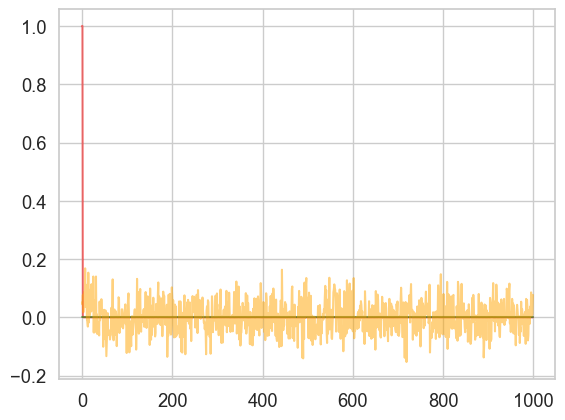

In [22]:
n_trace, C_trace = oopsi.fast(filtered_dff[0][0:1000], dt=dt, iter_max=100, update=True)
# n

plt.plot(n_trace, label="OOPSI DFF", color="red", alpha=0.5)
plt.plot(C_trace, label="OOPSI C", color="green", alpha=0.5)
plt.plot(filtered_dff[0][0:1000], label="Filtered DFF", color="orange", alpha=0.5)

In [38]:
list_input = np.array(
    filtered_dff_df[filtered_dff_df["Neuron"] == 1]["FilteredDFF"].values
)
list_input

array([ 0.05975808,  0.02123568, -0.00706481, ..., -0.01863571,
       -0.02648942, -0.03009344], shape=(36295,))

In [39]:
n, C = run_oopsi_single(list_input, dt=dt)

In [41]:
# how many spikes were detected?
print(f"Number of spikes detected: {np.sum(n >= 0.5)}")

Number of spikes detected: 36288


In [84]:
oopsi_spikes = np.load("oopsi_results_3.npz", allow_pickle=True)[
    "spikes"
]  # Load the spikes from the saved file
# print total number of spikes detected
oopsi_bool = oopsi_spikes >= 0.75  # Convert to boolean array
print(f"Total number of spikes detected by OOPSI: {oopsi_bool.sum()}")

Total number of spikes detected by OOPSI: 430486


In [ ]:
# add oopsi spikes to the filtered_dff_df
filtered_dff_df.drop(columns=["OOPSI_Spikes"], inplace=True)
filtered_dff_df["OOPSI_Spikes"] = 0
for neuron_id in filtered_dff_df["Neuron"].unique():
    neuron_mask = filtered_dff_df["Neuron"] == neuron_id
    filtered_dff_df.loc[neuron_mask, "OOPSI_Spikes"] = oopsi_spikes[neuron_id - 1]



/var/folders/_w/fvv3yfg57mj4b3g4yftq72cr0000gn/T/ipykernel_868/3562673903.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[8.395601667927194e-07 8.395601667927194e-07 0.7577022916725048 ...
 8.757536415050498e-11 2.654385006222134e-10 1.937740668750836e-10]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  filtered_dff_df.loc[neuron_mask, "OOPSI_Spikes"] = oopsi_spikes[neuron_id - 1]


,Neuron,Trial,Epoch,FrameIdx,Frequency,BlankSweep,Dir,relTime,FilteredDFF,Spike,OOPSI_Spikes
6405,106,1,1,747,1.0,0.0,225.0,0,0.010378,0,0.0
6406,106,1,1,748,1.0,0.0,225.0,1,0.026256,0,0.0
6407,106,1,1,749,1.0,0.0,225.0,2,0.043413,0,0.158824
6408,106,1,1,750,1.0,0.0,225.0,3,0.060231,0,0.158918
6409,106,1,1,751,1.0,0.0,225.0,4,0.072464,0,0.036442
...,...,...,...,...,...,...,...,...,...,...,...
4040397,106,628,3,115211,1.0,0.0,180.0,56,-0.008863,0,0.0
4040398,106,628,3,115212,1.0,0.0,180.0,57,-0.012682,0,0.0
4040399,106,628,3,115213,1.0,0.0,180.0,58,-0.014908,0,0.0
4040400,106,628,3,115214,1.0,0.0,180.0,59,-0.013319,0,0.0


In [85]:
# make all values in the OOPSI_Spikes column
filtered_dff_df["OOPSI_Spikes"] = filtered_dff_df["OOPSI_Spikes"] >= 0.75

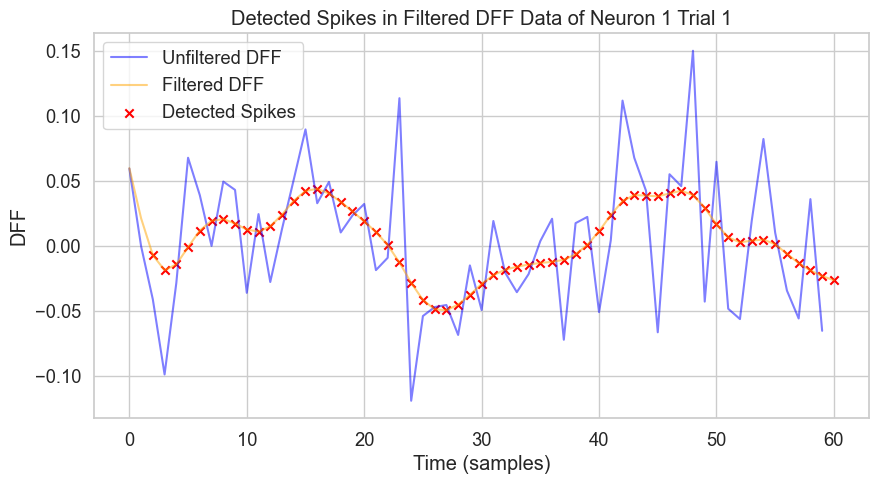

In [88]:
# get start and end of the first trial
start, end = stim_table.iloc[0][["start", "end"]].astype(int)

# filter the dataframe for neuron 1 and trial 1
neuron1_trial1 = filtered_dff_df[
    (filtered_dff_df["Neuron"] == 1) & (filtered_dff_df["Trial"] == 1)
]

neuron1_trial1["FilteredDFF"][start:end]
# plot trial 1 for neuron 1
plt.figure(figsize=(10, 5))
plt.plot(data["dff"][0][start:end], label="Unfiltered DFF", color="blue", alpha=0.5)
plt.plot(
    neuron1_trial1["FilteredDFF"],
    label="Filtered DFF",
    color="orange",
    alpha=0.5,
)
# add spikes
plt.scatter(
    neuron1_trial1.index[
        neuron1_trial1["OOPSI_Spikes"] == 1
    ],  # get the indices of the spikes
    neuron1_trial1["FilteredDFF"][neuron1_trial1["OOPSI_Spikes"] == 1],
    # get the filtered DFF values at the spike indices
    color="red",
    label="Detected Spikes",
    marker="x",
)
plt.title("Detected Spikes in Filtered DFF Data of Neuron 1 Trial 1")
plt.xlabel("Time (samples)")
plt.ylabel("DFF")
plt.legend()
plt.show()

In [18]:
from oasis.functions import (
    gen_data,
    gen_sinusoidal_data,
    deconvolve,
    estimate_parameters,
)
from oasis.plotting import simpleaxis
from oasis.oasis_methods import oasisAR1, oasisAR2

# run Oasis spike inference algorithm
for neuron in range(1, len(filtered_dff_df["Neuron"].unique() + 1)):
    print(f"Processing neuron {neuron}...")
    filtered_dff = filtered_dff_df[filtered_dff_df["Neuron"] == neuron][
        "FilteredDFF"
    ].values
    # Deconvolve the filtered dff data
    c, s, b, g, lam = deconvolve(filtered_dff, penalty=1)
    # concatenate the spikes as [neurons, frames]
    if neuron == 1:
        oasis_spikes = s.reshape(1, -1)
    else:
        oasis_spikes = np.concatenate((oasis_spikes, s.reshape(1, -1)), axis=0)
oasis_spikes

/Users/sascha/anaconda3/envs/NeuralDataScience/lib/python3.11/site-packages/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


Processing neuron 1...
Processing neuron 2...
Processing neuron 3...
Processing neuron 4...
Processing neuron 5...
Processing neuron 6...
Processing neuron 7...
Processing neuron 8...
Processing neuron 9...
Processing neuron 10...
Processing neuron 11...
Processing neuron 12...
Processing neuron 13...
Processing neuron 14...
Processing neuron 15...
Processing neuron 16...
Processing neuron 17...
Processing neuron 18...
Processing neuron 19...
Processing neuron 20...
Processing neuron 21...
Processing neuron 22...
Processing neuron 23...
Processing neuron 24...
Processing neuron 25...
Processing neuron 26...
Processing neuron 27...
Processing neuron 28...
Processing neuron 29...
Processing neuron 30...
Processing neuron 31...
Processing neuron 32...
Processing neuron 33...
Processing neuron 34...
Processing neuron 35...
Processing neuron 36...
Processing neuron 37...
Processing neuron 38...
Processing neuron 39...
Processing neuron 40...
Processing neuron 41...
Processing neuron 42...
P

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00, -2.71050543e-20,  2.71050543e-20],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.73472348e-18,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.73472348e-18,  1.73472348e-18,  8.67361738e-19],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  3.35808607e-04,  1.24609459e-02, ...,
         0.00000000e+00,  1.20310543e-03,  5.82555622e-03],
       [ 0.00000000e+00,  2.68214302e-02,  4.48685188e-03, ...,
         4.33680869e-19, -3.25260652e-19,  2.16840434e-19]],
      shape=(105, 36295))

In [20]:
# number of spikes detected
print(f"Number of spikes detected: {np.sum(oasis_spikes >= 0.5)}")

Number of spikes detected: 1379


## Segment data by stimulus presentation and epochs

Since we want to analyze each neuron´s preference for direction and frequency we need to look at the signal directly after a stimulus presentation. Therefore, we split the data into segements for each trial.

In [29]:
stims = data["stim_table"]
# convert start and end times to integers
stims["start"] = stims["start"].astype(int)
stims["end"] = stims["end"].astype(int)
stims

,frequency,direction,blank_sweep,start,end
0,1.0,225.0,0.0,747,807
1,2.0,180.0,0.0,837,897
2,4.0,90.0,0.0,927,987
3,1.0,270.0,0.0,1018,1077
4,4.0,135.0,0.0,1108,1168
...,...,...,...,...,...
623,4.0,315.0,0.0,114794,114854
624,2.0,45.0,0.0,114884,114944
625,4.0,180.0,0.0,114975,115034
626,4.0,270.0,0.0,115065,115125


In [30]:
# remove the blank sweeps
stims = stims[stims["blank_sweep"] == 0]
stims

,frequency,direction,blank_sweep,start,end
0,1.0,225.0,0.0,747,807
1,2.0,180.0,0.0,837,897
2,4.0,90.0,0.0,927,987
3,1.0,270.0,0.0,1018,1077
4,4.0,135.0,0.0,1108,1168
...,...,...,...,...,...
623,4.0,315.0,0.0,114794,114854
624,2.0,45.0,0.0,114884,114944
625,4.0,180.0,0.0,114975,115034
626,4.0,270.0,0.0,115065,115125


In [31]:
def build_spike_dataframe(dff, spikes_all, stims):
    """
    builds a dataframe containing spike information matched to stimulation trials.
    for each spike, includes neuron index, trial index, frame index, frequency, direction, relative time, and dff value.

    inputs:
    - dff: array of shape (neurons, frames), containing dff signal values
    - spikes_all: list of arrays, each containing spike frame indices for each neuron
    - stims: dataframe containing columns 'start', 'end', 'frequency', and 'direction'

    output:
    - spike_df: dataframe with spike and stimulation information
    """

    # create an intervalindex from start and end
    intervals = pd.IntervalIndex.from_arrays(
        stims["start"], stims["end"], closed="both"
    )

    # flatten all spike times
    spikes_all_flat = np.concatenate(spikes_all)

    # find for each spike time which trial (if any) it belongs to
    spike_trial_idx = intervals.get_indexer(spikes_all_flat)

    # convert spike_times_all into flat arrays with neuron indices and spike frame indices
    neuron_indices = []
    spike_frame_indices_flat = []
    frequency_flat = []

    for neuron_idx, spikes in enumerate(spikes_all):
        neuron_indices.extend([neuron_idx] * len(spikes))
        spike_frame_indices_flat.extend(spikes)
        frequency_flat.extend(
            [stims.iloc[spike_trial_idx[i]]["frequency"] for i in range(len(spikes))]
        )

    # build dataframe with matched trials
    spike_df = pd.DataFrame(
        {
            "Neuron": [i for i in neuron_indices],
            "Trial": spike_trial_idx,
            "FrameIdx": spike_frame_indices_flat,
            "Frequency": frequency_flat,
        }
    )

    # filter out spikes that did not match any trial (index -1)
    spike_df = spike_df[spike_df["Trial"] != -1]

    # add stim info
    spike_df = spike_df.merge(
        stims[["direction"]].reset_index(),
        left_on="Trial",
        right_on="index",
        how="left",
    )

    spike_df = spike_df.rename(columns={"direction": "Dir"}).drop(columns=["index"])

    # add time relative to the start of the trial
    spike_df["relTime"] = spike_df["FrameIdx"] - spike_df["Trial"].map(
        lambda trial: stims.iloc[trial]["start"]
    )

    # get dff values using neuron index and frame index
    dff_values = np.array(
        [dff[n, f] for n, f in zip(spike_df["Neuron"], spike_df["FrameIdx"])]
    )

    # add dff column
    spike_df["DFF"] = dff_values

    # remove nans from Dir
    spike_df = spike_df[spike_df["Dir"].notna()]

    return spike_df


spike_df = build_spike_dataframe(
    dff=filtered_dff_all,
    spikes_all=oasis_spikes,
    stims=stims,
)
spike_df

NameError: name 'oasis_spikes' is not defined

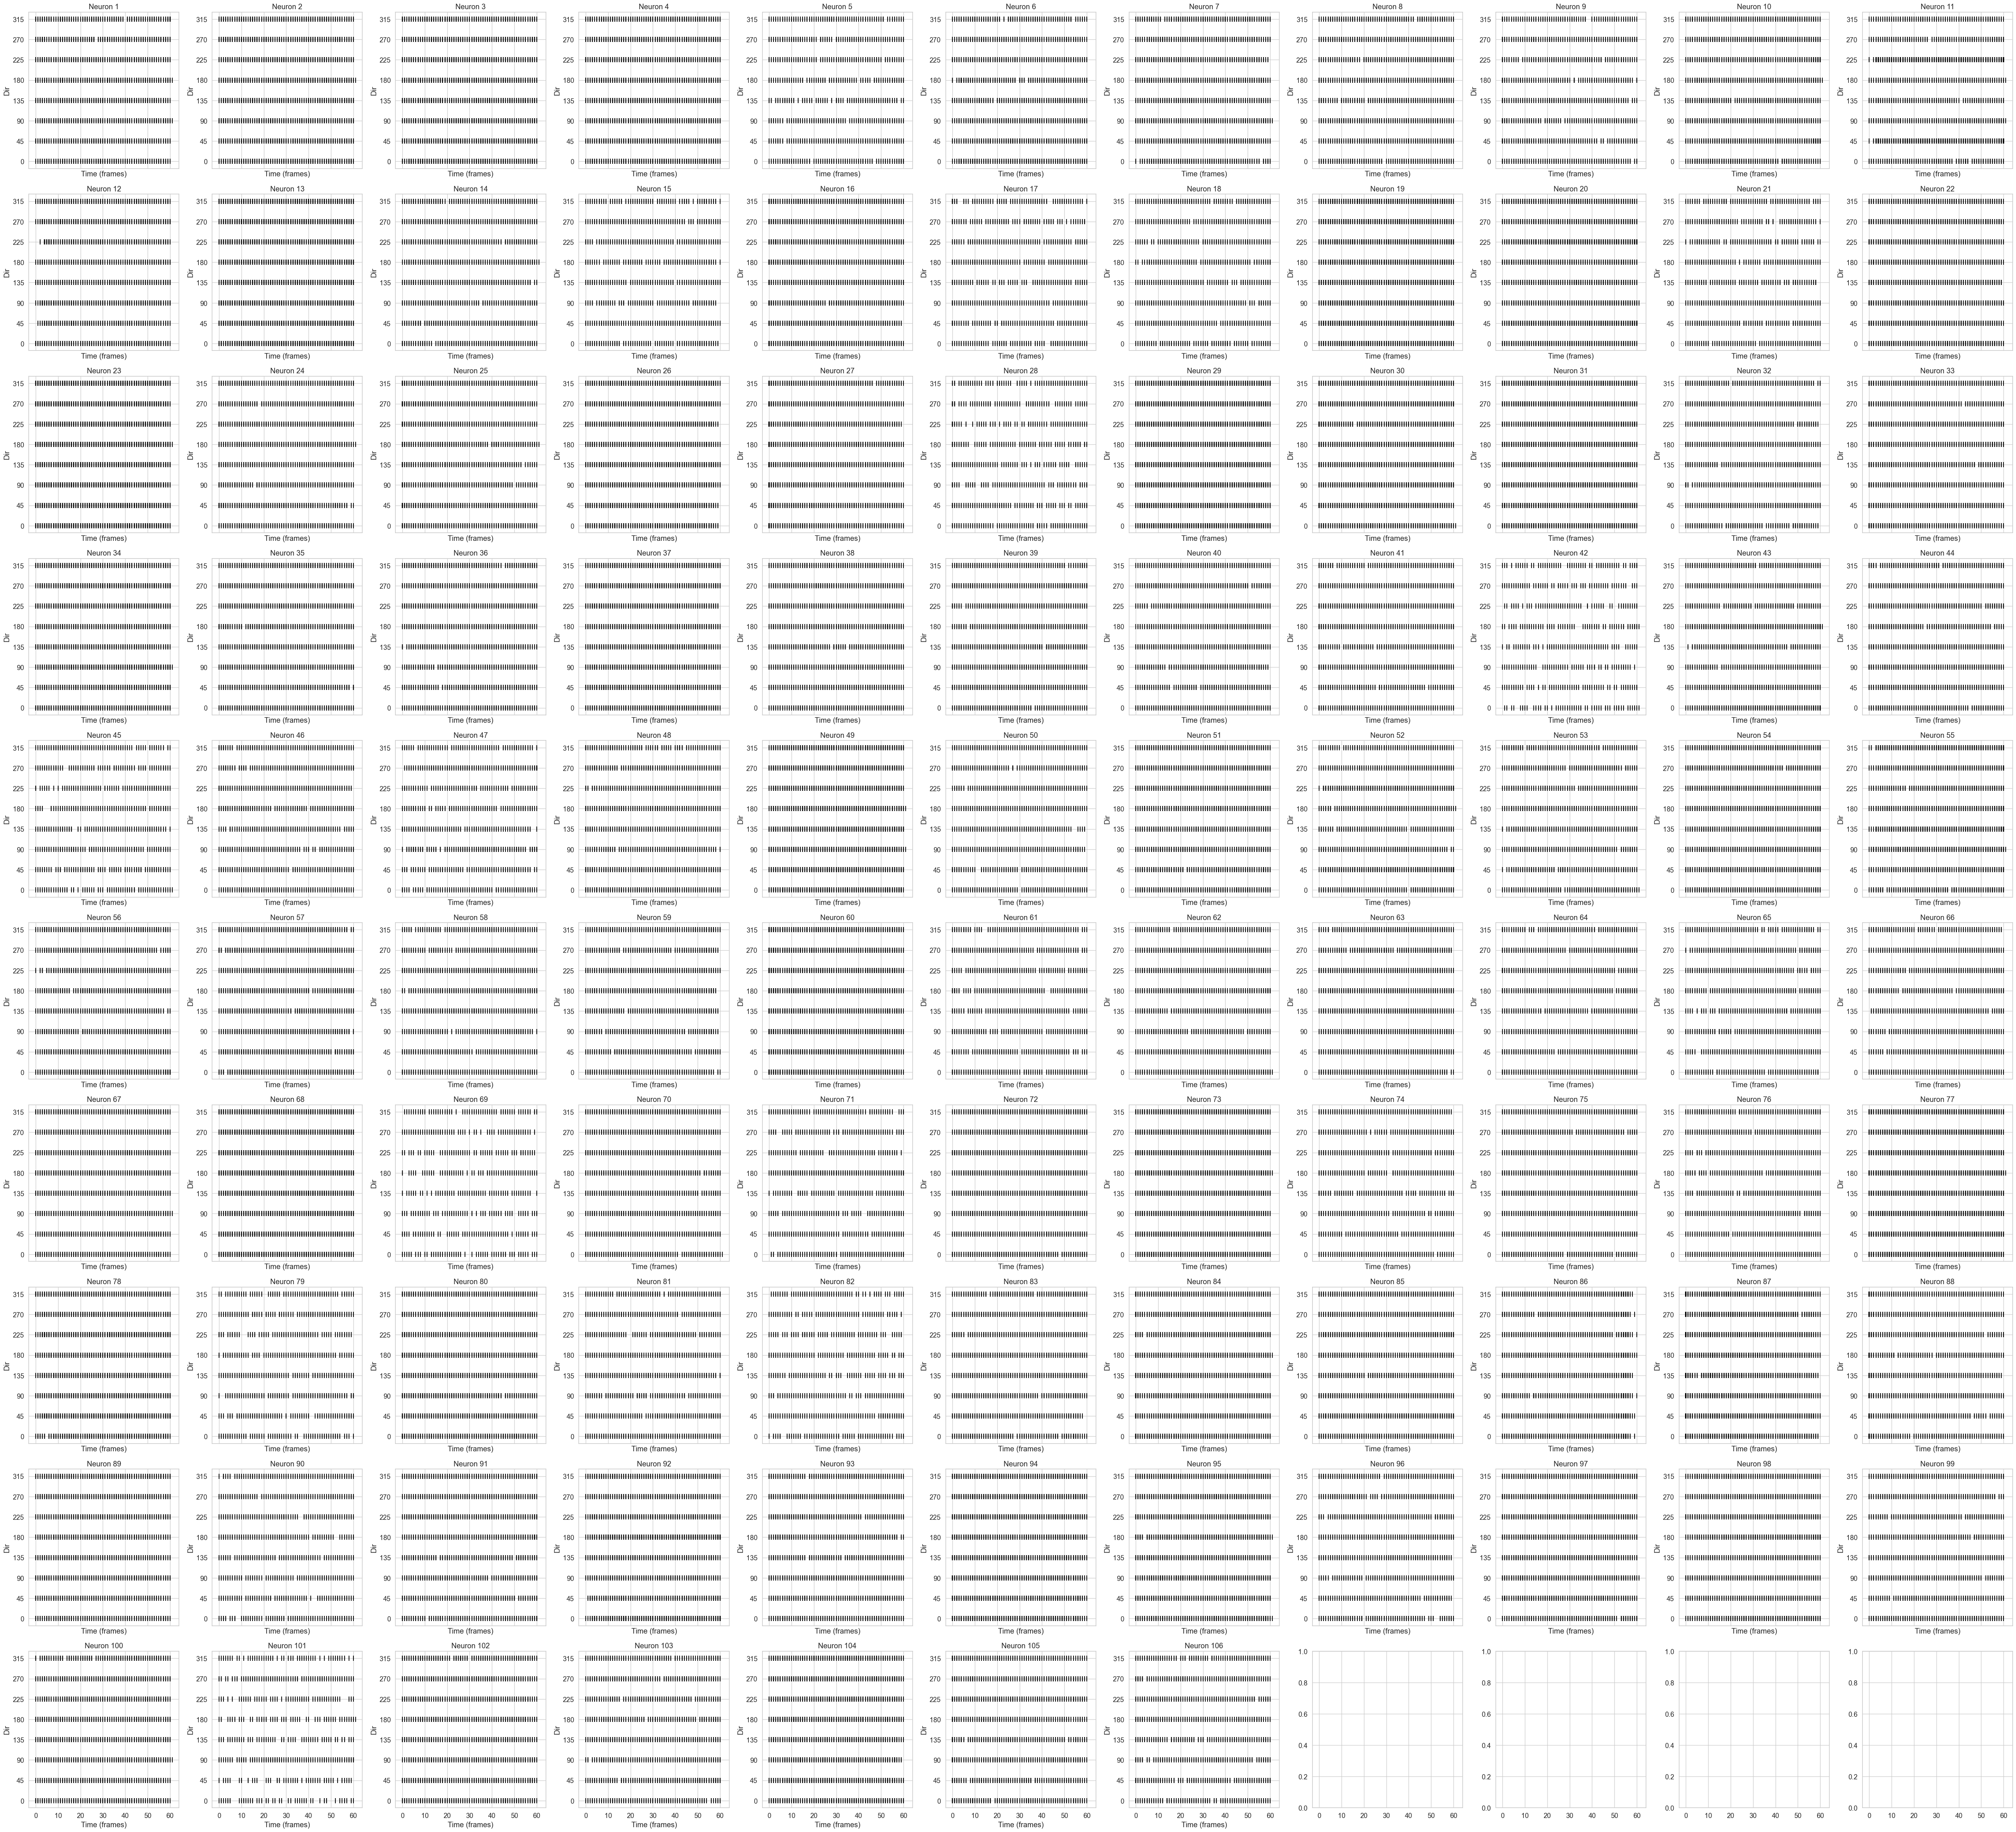

In [33]:
# Plot spike rasters for multiple neurons sorted by direction
def plotRaster(
    spikes: pd.DataFrame, neurons: list, delta, max_y, condition, stimDur=60
):
    """Plot spike rasters for multiple neurons sorted by condition.

    Parameters
    ----------
    spikes: pd.DataFrame
        Pandas DataFrame with columns
            Neuron | SpikeTimes | Dir | relTime | Trial | stimPeriod

    neurons: list
        List of neuron IDs to plot.

    deltaDir: int
        Step size for y-axis ticks.

    stimDur: int
        Duration of the stimulus in frames.

    condition: str
        Condition to sort by, can be 'Dir', 'Frequency', etc.

    Note
    ----
    This function does not return anything, it just creates a plot!
    """

    # -------------------------------------------------
    # Write a raster plot function for the data (2 pts)
    # -------------------------------------------------

    # create subplots based on the number of neurons
    n_neurons = len(neurons)
    n_cols = int(np.ceil(np.sqrt(n_neurons)))
    n_rows = int(np.ceil(n_neurons / n_cols))
    fig, axes = plt.subplots(
        n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows), sharex=True
    )

    # flatten axes array and trim excess if needed
    axes = axes.flatten()

    # ensure axes is iterable even for a single neuron
    if n_neurons == 1:
        axes = [axes]

    for ax, neuron in zip(axes, neurons):
        # filter data for the current neuron
        x = spikes.loc[spikes["Neuron"] == neuron, "relTime"]
        y = spikes.loc[spikes["Neuron"] == neuron, condition]

        # create a scatter plot on the provided axis
        ax.scatter(x, y, marker="|", color="black", s=100)
        ax.set_xlabel("Time (frames)")
        ax.set_ylabel(condition)
        ax.set_title(f"Neuron {neuron}")
        ax.set_yticks(np.arange(0, max_y, delta))
        ax.set_xticks(np.arange(0, stimDur + 1, 10))

    plt.tight_layout()
    plt.show()


stimDur = 60  # duration of the stimulus in frames
deltaDir = 45  # direction step in degrees
deltaFreq = 1  # frequency step in Hz
condition = "Dir"  # condition to sort by, can be 'Dir', 'Frequency'
max_y = 360  # maximum y value for the plot


plotRaster(
    spike_df,
    neurons=list(range(1, 107)),
    delta=deltaDir,
    max_y=max_y,
    condition=condition,
)

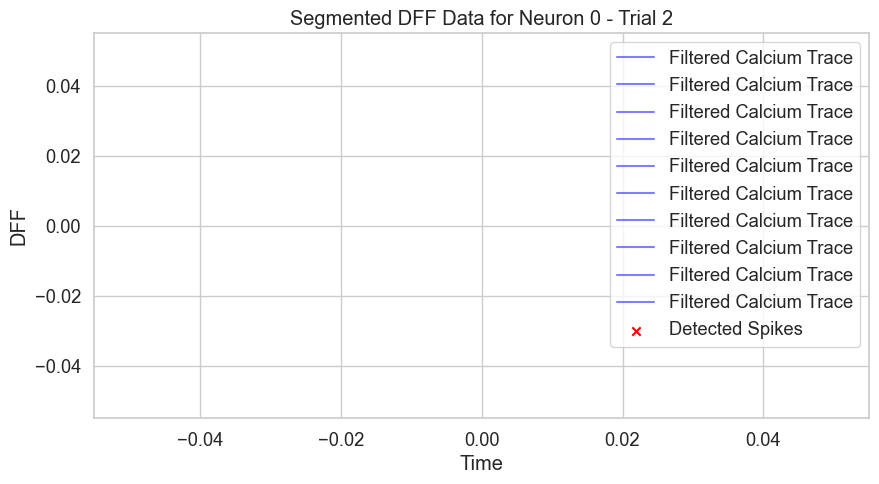

In [39]:
neuron_idx = 0  # index of the neuron to plot
trial_idx = 2  # index of the trial to plot
# plot the segmented data for the first stimulus epoch
stims = data["stim_table"]
start, end = stims.iloc[trial_idx]["start"], stims.iloc[trial_idx]["end"]
filtered_segmented_data = filtered_dff_df[filtered_dff_df["Neuron"] == neuron_idx][
    int(start) : int(end)
]
plt.figure(figsize=(10, 5))
plt.plot(
    filtered_segmented_data, label=f"Filtered Calcium Trace", color="blue", alpha=0.5
)
plt.scatter(
    spike_df[(spike_df["Neuron"] == neuron_idx) & (spike_df["Trial"] == trial_idx)][
        "relTime"
    ],
    spike_df[(spike_df["Neuron"] == neuron_idx) & (spike_df["Trial"] == trial_idx)][
        "FilteredDFF"
    ],
    color="red",
    label="Detected Spikes",
    marker="x",
)
plt.title(f"Segmented DFF Data for Neuron {neuron_idx} - Trial {trial_idx}")
plt.xlabel("Time")
plt.ylabel("DFF")
plt.legend()
plt.show()

## Tuning functions

In [40]:
# vonMises tuning curve estimation
def vonMises(
    theta: np.ndarray, alpha: float, kappa: float, ny: float, phi: float
) -> np.ndarray:
    """Evaluate the parametric von Mises tuning curve with parameters p at locations theta.

    Parameters
    ----------

    θ: np.array, shape=(N, )
        Locations. The input unit is degree.

    α, κ, ν, ϕ : float
        Function parameters

    Return
    ------
    f: np.array, shape=(N, )
        Tuning curve.
    """

    theta, phi = np.deg2rad(theta), np.deg2rad(phi)

    return np.exp(
        alpha + kappa * (np.cos(2 * (theta - phi)) - 1) + ny * (np.cos(theta - phi) - 1)
    )

In [41]:
def tuningCurve(
    counts: np.ndarray, dirs: np.ndarray, neuron, show: bool = True
) -> np.ndarray:
    """Fit a von Mises tuning curve to the spike counts in count with direction dir using a least-squares fit.

    Parameters
    ----------

    counts: np.array, shape=(total_n_trials, )
        the spike count during the stimulation period

    dirs: np.array, shape=(total_n_trials, )
        the stimulus direction in degrees

    show: bool, default=True
        Plot or not.


    Return
    ------
    p: np.array or list, (4,)
        parameter vector of tuning curve function
    """
    (alpha, kappa, ny, phi), _ = opt.curve_fit(vonMises, dirs, counts, maxfev=100000)

    if show:

        theta = np.linspace(0, 360, 1000)
        fig, ax = plt.subplots(figsize=(8, 4))
        fig.suptitle(f"Von Mises Tuning Curve for Neuron {neuron}", fontsize=16)
        ax.plot(dirs, counts.mean(axis=1), "o", label="Data")
        ax.plot(theta, vonMises(theta, alpha, kappa, ny, phi), label="Fitted Curve")
        ax.set_xlabel("Direction (degrees)")
        ax.set_ylabel("Spike Count")
        ax.set_title(
            f"Alpha: {alpha:.2f}, Kappa: {kappa:.2f}, Ny: {ny:.2f}, Phi: {phi:.2f}"
        )
        ax.set_xlim(0, 360)
        ax.set_ylim(0, counts.max() * 1.2)
        ax.set_xticks(np.arange(0, 361, 45))
        ax.set_xticklabels(np.arange(0, 361, 45))
        ax.set_yticks(np.arange(0, counts.max() * 1.2, 5))
        ax.set_yticklabels(np.arange(0, counts.max() * 1.2, 5))
        ax.grid()
        ax.legend()
        plt.show()
    return np.array([alpha, kappa, ny, phi])

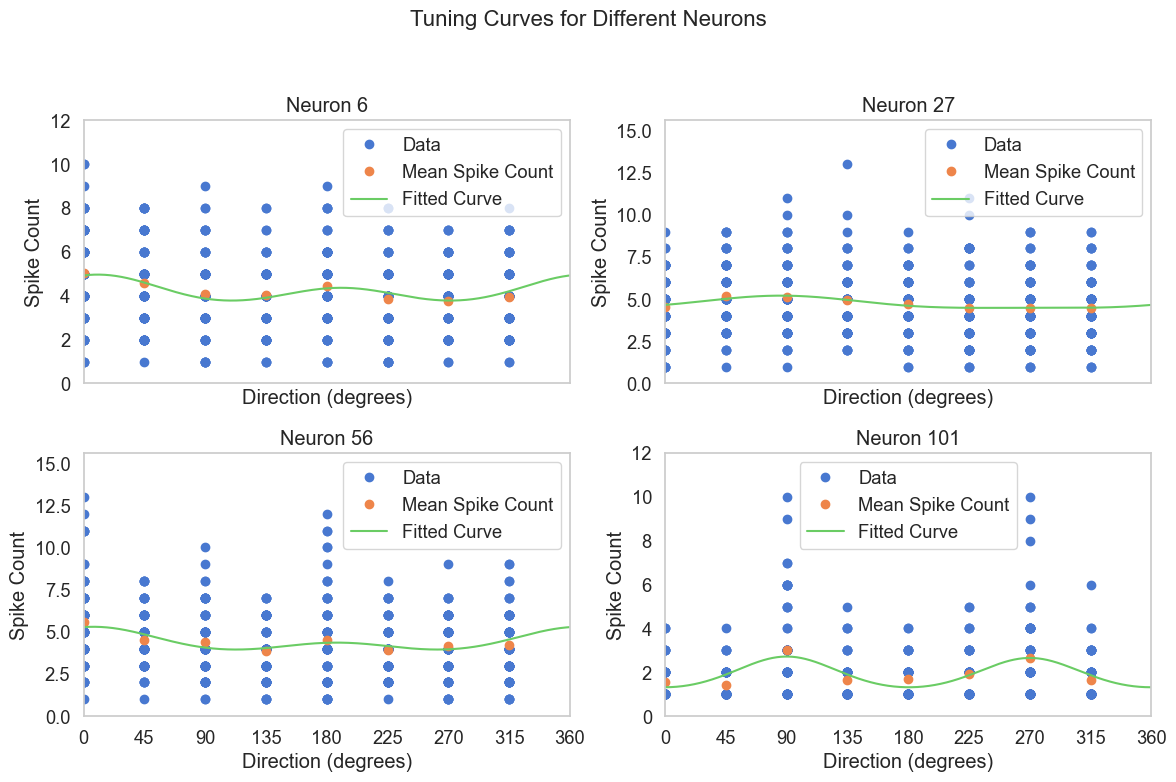

In [53]:
def get_data(neurons_df, neuron):
    # Filter for the given neuron
    spk_by_dir = (
        neurons_df[neurons_df["Neuron"] == neuron]
        .groupby(["Dir", "Trial"])
        .size()  # Count the number of spikes per direction and trial
        .reset_index(name="spike_count")
    )

    dirs = spk_by_dir["Dir"].values
    counts = spk_by_dir["spike_count"].values

    # Ensure zero entries for missing directions
    for direction in np.unique(neurons_df["Dir"]):
        if direction not in dirs:
            dirs = np.append(dirs, direction)
            counts = np.append(counts, 0)

    idx = np.argsort(dirs)
    dirs_sorted = dirs[idx]
    counts_sorted = counts[idx]

    return dirs_sorted, counts_sorted


# List of neurons to plot
neurons = [6, 27, 56, 101]  # Example neuron indices, adjust as needed

fig, axes = plt.subplots(len(neurons) // 2, 2, figsize=(12, 8), sharex=True)
fig.suptitle("Tuning Curves for Different Neurons", fontsize=16)
axes = axes.flatten()

for i, neuron in enumerate(neurons):
    ax = axes[i]
    dirs, counts = get_data(spike_df, neuron)

    unique_dirs = np.sort(np.unique(dirs))
    df = pd.DataFrame({"Counts": counts, "Direction": dirs}).groupby("Direction").mean()

    α0 = np.log(np.max(df.values.flatten()) + 1e-3)
    ϕ0 = unique_dirs[np.argmax(df.values.flatten())]
    p0 = [α0, 1.0, 1.0, ϕ0]

    try:
        p, _ = opt.curve_fit(
            vonMises, df.index.values, df.values.flatten(), p0=p0, maxfev=10000
        )
    except RuntimeError:
        p = p0  # fallback to initial guess if fitting fails

    ax.plot(dirs, counts, "o", label="Data")
    ax.plot(df.index.values, df.values.flatten(), "o", label="Mean Spike Count")
    theta = np.linspace(0, 360, 1000)
    ax.plot(theta, vonMises(theta, *p), label="Fitted Curve")
    ax.set_title(f"Neuron {neuron}")
    ax.set_xlabel("Direction (degrees)")
    ax.set_ylabel("Spike Count")
    ax.set_xlim(0, 360)
    ax.set_ylim(0, counts.max() * 1.2)
    ax.set_xticks(np.arange(0, 361, 45))
    ax.grid()
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 4 Statistical Testing
## 4.1 Permutation Test

In [43]:
def testTuning(
    counts: np.ndarray,
    dirs: np.ndarray,
    psi: int = 1,
    niters: int = 1000,
    show: bool = False,
    random_seed: int = 2046,
) -> Tuple[float, float, np.ndarray]:
    """Plot the data if show is True, otherwise just return the fit.

    Parameters
    ----------

    counts: np.array, shape=(total_n_trials, )
        the spike count during the stimulation period

    dirs: np.array, shape=(total_n_trials, )
        the stimulus direction in degrees

    psi: int
        fourier component to test (1 = direction, 2 = orientation)

    niters: int
        Number of iterations / permutation

    show: bool
        Plot or not.

    random_seed: int
        Random seed for reproducibility.

    Returns
    -------
    p: float
        p-value
    q: float
        magnitude of second Fourier component

    qdistr: np.array
        sampling distribution of |q| under the null hypothesis

    """

    # calculate vector of average spike counts for each unique direction
    unique_dirs = np.sort(np.unique(dirs))
    m = np.array([np.mean(counts[dirs == d]) for d in unique_dirs])

    # define complex exponential vector with fourier component [1, 2]
    v = np.exp(1j * psi * np.deg2rad(unique_dirs))

    # compute observed projection
    q = np.dot(m, v)
    q_mag = np.abs(q)

    # ensure reproducibility using a random number generator
    # hint: access random functions of this generator
    rng = np.random.default_rng(random_seed)
    qdistr = np.zeros(niters)
    for i in range(niters):
        # shuffle the counts across trials
        shuffled_counts = rng.permutation(counts)
        # recompute average spike counts for each direction using shuffled data
        m_perm = np.array([np.mean(shuffled_counts[dirs == d]) for d in unique_dirs])
        # compute projection for shuffled data
        q_perm = np.dot(m_perm, v)
        qdistr[i] = np.abs(q_perm)

    # calculate the p-value as the fraction of permuted |q| more extreme than observed
    p = np.mean(qdistr > q_mag)

    # if show is true, plot the null distribution and the observed value
    if show:
        plt.figure(figsize=(8, 5))
        plt.hist(qdistr, bins=30, alpha=0.7, label="null distribution")
        plt.axvline(q_mag, color="red", linestyle="--", label="observed |q|")
        plt.xlabel("|q|")
        plt.ylabel("frequency")
        plt.title(f"Permutation test (psi = {psi})\np-value = {p:.4f}")
        plt.legend()
        plt.show()

    return p, q_mag, qdistr

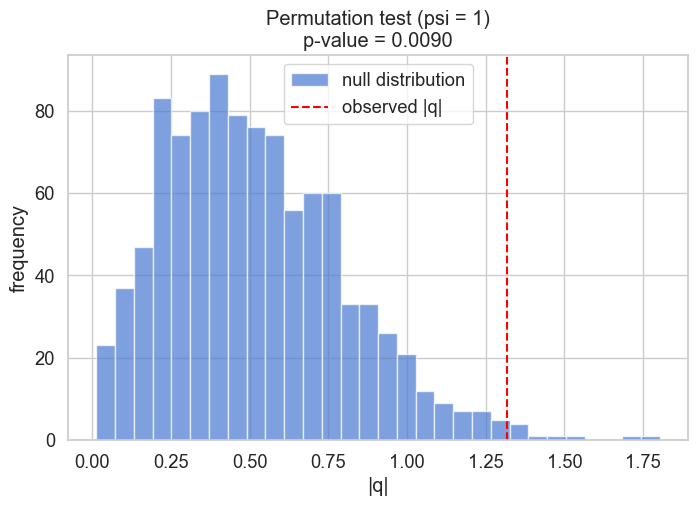

Neuron 6: p-value = 0.0090, |q| = 1.3174


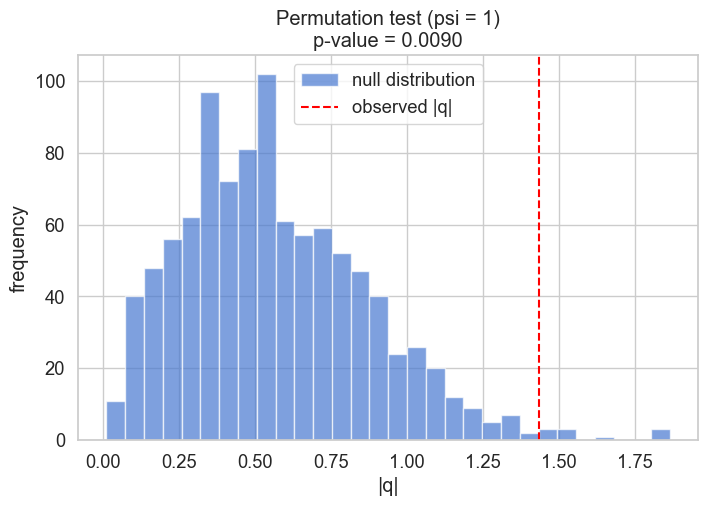

Neuron 27: p-value = 0.0090, |q| = 1.4347


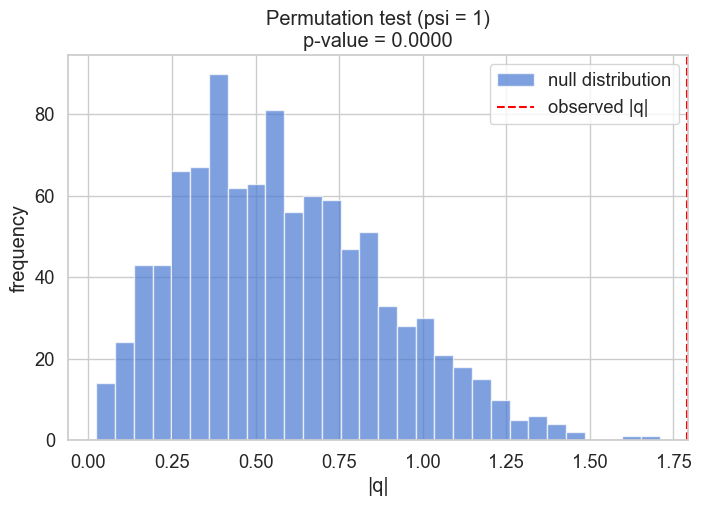

Neuron 56: p-value = 0.0000, |q| = 1.7916


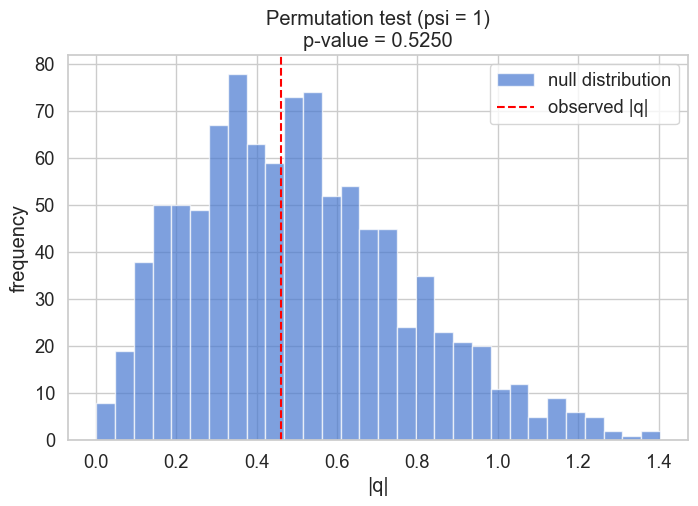

Neuron 101: p-value = 0.5250, |q| = 0.4607


In [52]:
neurons = [6, 27, 56, 101]  # Example neuron indices, adjust as needed
for neuron in neurons:
    dirs, counts = get_data(spike_df, neuron)
    p, q, qdistr = testTuning(counts, dirs, show=True)
    print(f"Neuron {neuron}: p-value = {p:.4f}, |q| = {q:.4f}")

In [48]:
# --------------------------------------------------
# Test all cells for orientation / direction tuning.
# Which ones are selective? (0.5 pts)
# --------------------------------------------------

# get unique neurons
neurons = spike_df["Neuron"].unique()
# create a DataFrame to store the results
results = pd.DataFrame(
    columns=[
        "Neuron",
        "p-value (direction)",
        "p-value (orientation)",
        "|q| (direction)",
        "|q| (orientation)",
    ]
)
# create lists to store results
p_values_dir = []
p_values_ori = []
q_values_dir = []
q_values_ori = []
# loop through all neurons and test for direction tuning
for neuron in neurons:
    dirs, counts = get_data(spike_df, neuron)
    p_dir, q_dir, _ = testTuning(counts, dirs, psi=1, show=False)
    p_ori, q_ori, _ = testTuning(counts, dirs, psi=2, show=False)
    # append results to lists
    p_values_dir.append(p_dir)
    p_values_ori.append(p_ori)
    q_values_dir.append(q_dir)
    q_values_ori.append(q_ori)

# make dataframe
results = pd.DataFrame(
    {
        "Neuron": neurons,
        "p-value (direction)": p_values_dir,
        "p-value (orientation)": p_values_ori,
        "|q| (direction)": q_values_dir,
        "|q| (orientation)": q_values_ori,
    }
)

# add a column for significance
results["Significant (direction)"] = results["p-value (direction)"] < 0.01
results["Significant (orientation)"] = results["p-value (orientation)"] < 0.01

In [49]:
print(
    "The following neurons are selective for direction: ",
    results.loc[results["Significant (direction)"], "Neuron"].values,
)
print(
    "Number of neurons selective for direction: ",
    results.loc[results["Significant (direction)"], "Neuron"].count(),
)

The following neurons are selective for direction:  [ 6 27 56]
Number of neurons selective for direction:  3


In [50]:
print(
    "The following neurons are selective for orientation: ",
    results.loc[results["Significant (orientation)"], "Neuron"].values,
)
print(
    "Number of neurons selective for orientation: ",
    results.loc[results["Significant (orientation)"], "Neuron"].count(),
)

The following neurons are selective for orientation:  [  6  11  12  20  30  34  43  47  52  55  56  62  71  78  79  85  92  98
 101]
Number of neurons selective for orientation:  19
